# HW3 Practical: Comparing Generative Paradigms on CIFAR-10


Welcome! This notebook provides the training and evaluation pipeline for the four generative models `models/`.

- Run the setup cells to install dependencies and load CIFAR-10.

In [ ]:
# Install lightweight dependencies (safe to re-run)
!pip install torch-fidelity tqdm


In [ ]:
!pip install numpy matplotlib torch torchvision torchaudio

In [31]:
import math
import time
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from tqdm.auto import tqdm
import torch.nn.functional as F

from cifar10 import load_cifar10
from models.gan import DCGAN
from models.vae import ConvVAE
from models.pixelcnn import PixelCNN
from models.ddpm import DenoiseUNet

from torch_fidelity import calculate_metrics

In [ ]:
# Global configuration
PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT
ARTIFACT_DIR = PROJECT_ROOT / "artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

BATCH_SIZE = 128
NUM_WORKERS = 2
IMAGE_SIZE = 32
NUM_CLASSES = 10

print(f"Using device: {DEVICE}")
if DEVICE.type == "cuda":
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
print(f"Project root: {PROJECT_ROOT}")

#this implementation used
# Using device: cuda
# GPU: Tesla V100-SXM2-32GB

### Experiment presets

The dictionaries below define the baseline ("small") and scaled ("medium") configurations used in this. Baselines train for 30 epochs, and the scaled variants run for 40 epochs so can contrast added capacity with extra compute.

In [3]:
EXPERIMENT_CONFIGS = {
    "dcgan": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 128, "epochs": 40, "lr": 2e-4},
    },
    "vae": {
        "small": {"base_channels": 64, "latent_dim": 128, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "latent_dim": 192, "epochs": 40, "lr": 2e-4},
    },
    "pixelcnn": {
        "small": {"hidden_channels": 64, "residual_layers": 5, "epochs": 30, "lr": 3e-4},
        "medium": {"hidden_channels": 96, "residual_layers": 7, "epochs": 40, "lr": 3e-4},
    },
    "ddpm": {
        "small": {"base_channels": 64, "time_channels": 256, "timesteps": 1000, "epochs": 30, "lr": 2e-4},
        "medium": {"base_channels": 96, "time_channels": 256, "timesteps": 750, "epochs": 40, "lr": 2e-4},
    },
}

EXPERIMENT_CONFIGS


{'dcgan': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 128,
   'epochs': 40,
   'lr': 0.0002}},
 'vae': {'small': {'base_channels': 64,
   'latent_dim': 128,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'latent_dim': 192,
   'epochs': 40,
   'lr': 0.0002}},
 'pixelcnn': {'small': {'hidden_channels': 64,
   'residual_layers': 5,
   'epochs': 30,
   'lr': 0.0003},
  'medium': {'hidden_channels': 96,
   'residual_layers': 7,
   'epochs': 40,
   'lr': 0.0003}},
 'ddpm': {'small': {'base_channels': 64,
   'time_channels': 256,
   'timesteps': 1000,
   'epochs': 30,
   'lr': 0.0002},
  'medium': {'base_channels': 96,
   'time_channels': 256,
   'timesteps': 750,
   'epochs': 40,
   'lr': 0.0002}}}

In [ ]:
THROUGHPUT_SAMPLES = {
    "dcgan": 1024,
    "vae": 1024,
    "pixelcnn": 1024,  # autoregressive sampling is slow; document  actual sample count if changed
    "ddpm": 1024,
}

THROUGHPUT_SAMPLES


{'dcgan': 1024, 'vae': 1024, 'pixelcnn': 1024, 'ddpm': 1024}

## Data loading


In [5]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


In [6]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=True,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = load_cifar10(
        root=str(DATA_ROOT),
        batch_size=batch_size,
        train=False,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, val_loader


set_seed(SEED)
train_loader, val_loader = get_dataloaders()
print(f"Train batches: {len(train_loader)}, Validation batches: {len(val_loader)}")


Train batches: 391, Validation batches: 79


## Utility functions


In [ ]:

from cifar10 import ArrayDataset
def to_device(batch, device=DEVICE):
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}


def images_to_uint8(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor.detach().cpu().clamp(0.0, 1.0)
    tensor = (tensor * 255.0).round().to(torch.uint8)
    return tensor.permute(0, 2, 3, 1).numpy()


def save_image_grid(images: torch.Tensor, path: Path, nrow: int = 8):
    path.parent.mkdir(parents=True, exist_ok=True)
    grid = make_grid(images.detach().cpu(), nrow=nrow, padding=2)
    save_image(grid, str(path))
    return grid


def gather_real_images(loader: DataLoader, max_samples: int = 2048) -> torch.Tensor:
    batches = []
    total = 0
    for batch in loader:
        imgs = batch["images"]
        batches.append(imgs)
        total += imgs.size(0)
        if total >= max_samples:
            break
    return torch.cat(batches, dim=0)[:max_samples]


# from torch.utils.data import Dataset

# class _ArrayDataset(Dataset):
#     def __init__(self, array: np.ndarray):
#         self.array = array

#     def __len__(self) -> int:
#         return self.array.shape[0]

#     def __getitem__(self, idx: int):
#         arr = self.array[idx]
#         tensor = torch.from_numpy(arr).permute(2, 0, 1).contiguous()
#         return tensor

def compute_kid_score(real_images: torch.Tensor, fake_images: torch.Tensor) -> float:
    real_np = images_to_uint8(real_images)
    fake_np = images_to_uint8(fake_images)

    metrics = calculate_metrics(
        input1=ArrayDataset(fake_np),#input1=_ArrayDataset(fake_np),
        input2=ArrayDataset(real_np),#input2=_ArrayDataset(real_np),
        kid=True,
        fid=False,
        verbose=False,
    )
    kid_key = "kernel_inception_distance_mean"
    if kid_key not in metrics:
        kid_key = "kid_mean"
    kid_value = metrics.get(kid_key)
    if kid_value is None:
        raise KeyError(f"KID metric missing expected keys: {list(metrics.keys())}")
    return float(kid_value)


def measure_sampling_throughput(sample_fn, num_images: int = 1024, device=DEVICE):
    torch.cuda.empty_cache()
    torch.cuda.synchronize() if device.type == "cuda" else None
    start = time.perf_counter()
    samples = sample_fn(num_images=num_images, device=device)
    torch.cuda.synchronize() if device.type == "cuda" else None
    elapsed = time.perf_counter() - start
    throughput = num_images / elapsed
    return samples, elapsed, throughput


def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [10]:
real_subset = gather_real_images(val_loader, max_samples=2048)
real_subset_device = real_subset.to(DEVICE)
print(f"Real subset cached: {real_subset.shape} (device copy: {real_subset_device.shape})")



Real subset cached: torch.Size([2048, 3, 32, 32]) (device copy: torch.Size([2048, 3, 32, 32]))


## Training loops


In [ ]:
def _init_history():
    return defaultdict(list)
  
def train_dcgan(model: DCGAN, dataloader: DataLoader, optimizer_g, optimizer_d, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DCGAN] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)

            model.zero_grad(set_to_none=True)
            optimizer_d.zero_grad(set_to_none=True)
            out_d = model({"images": images})
            loss_d = out_d["discriminator_loss"]
            loss_d.backward()
            optimizer_d.step()

            model.zero_grad(set_to_none=True)
            optimizer_g.zero_grad(set_to_none=True)
            out_g = model({"images": images})
            loss_g = out_g["generator_loss"]
            loss_g.backward()
            optimizer_g.step()

            history["d_loss"].append(loss_d.item())
            history["g_loss"].append(loss_g.item())
            progress.set_postfix({"d": loss_d.item(), "g": loss_g.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_vae(model: ConvVAE, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[VAE] Epoch {epoch+1}/{epochs}", leave=False)
        
        current_epoch_losses = []
        
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            
            history["loss"].append(loss.item())
            history["kl"].append(out["kl"].mean().item())
            history["recon"].append(out["reconstruction_loss"].mean().item())
            
            current_epoch_losses.append(loss.item())
            
            progress.set_postfix({"loss": loss.item()})
        
        avg_loss = sum(current_epoch_losses) / len(current_epoch_losses)
        history["epoch_loss"].append(avg_loss)        
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_pixelcnn(model: PixelCNN, dataloader: DataLoader, optimizer, epochs: int = 5, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[PixelCNN] Epoch {epoch+1}/{epochs}", leave=False)
        
        current_epoch_losses = []
        
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            
            history["loss"].append(loss.item())
            current_epoch_losses.append(loss.item())
            
            progress.set_postfix({"loss": loss.item()})
            
        avg_loss = sum(current_epoch_losses) / len(current_epoch_losses)
        history["epoch_loss"].append(avg_loss)

        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history


def train_ddpm(model: DenoiseUNet, dataloader: DataLoader, optimizer, epochs: int = 1, device=DEVICE):
    model.to(device)
    history = _init_history()
    epoch_times = []
    for epoch in range(epochs):
        start = time.perf_counter()
        progress = tqdm(dataloader, desc=f"[DDPM] Epoch {epoch+1}/{epochs}", leave=False)
        for batch in progress:
            images = batch["images"].to(device)
            optimizer.zero_grad(set_to_none=True)
            out = model({"images": images})
            loss = out["loss"]
            loss.backward()
            optimizer.step()
            history["loss"].append(loss.item())
            progress.set_postfix({"loss": loss.item()})
        epoch_times.append(time.perf_counter() - start)
    history["epoch_time"] = epoch_times
    return history



## Sampling & evaluation helper functions


In [ ]:

@torch.no_grad()
def sample_dcgan(model: DCGAN, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        #Using model.sample() over model.generator() 
        fake = model.sample(z) 
        samples.append(fake.detach().cpu())
    return torch.cat(samples, dim=0)


@torch.no_grad()
def sample_vae(model: ConvVAE, num_samples: int = 64, device=DEVICE, batch_size: int = 64):
    model.eval()
    model.to(device)
    samples = []
    for start in range(0, num_samples, batch_size):
        n = min(batch_size, num_samples - start)
        z = torch.randn(n, model.latent_dim, device=device)
        mean, logvar = model.decode(z) ### NOTE: decode the latent codes using the model
        std = torch.exp(0.5 * logvar)
        draw = model.reparameterize(mean, logvar, sample=True) ### NOTE: sample from the distribution
        samples.append(draw.detach().cpu())
    return torch.cat(samples, dim=0).clamp(0.0, 1.0)


@torch.no_grad()
def sample_pixelcnn(model: PixelCNN, num_samples: int = 16, device=DEVICE, image_size: int = IMAGE_SIZE):
    model.eval()
    model.to(device)
    bins = model.bins
    samples = torch.zeros(num_samples, model.image_channels, image_size, image_size, device=device)
    for row in range(image_size):
        for col in range(image_size):
            logits = model.net(samples) ### NOTE get the logits from the model 
            logits = logits.view(num_samples, model.image_channels, bins, image_size, image_size)
            probs = F.softmax(logits[:, :, :, row, col], dim=2) # NOTE: Softmax the logits (dim=2 is bins)### TODO: Softmax the logits to get the probability of each bin
            cat = torch.distributions.Categorical(probs=probs)
            pixel = cat.sample()
            pixel = pixel.float() / (bins - 1)
            samples[:, :, row, col] = pixel
    return samples.detach().cpu().clamp(0.0, 1.0)


@torch.no_grad()
def _ddpm_predict_noise(model: DenoiseUNet, xt: torch.Tensor, t: torch.Tensor):
    time_emb = model.time_embedding(t)
    h0 = model.model["init"](xt) ### NOTE: forward the input through the layers
    skip0, h1 = model.model["down0"](h0, time_emb) ### NOTE
    skip1, h2 = model.model["down1"](h1, time_emb)### NOTE
    skip2, h3 = model.model["down2"](h2, time_emb)### NOTE
    h_mid = model.model["mid"](h3, time_emb)### NOTE
    h = model.model["up2"](h_mid, skip2, time_emb)### NOTE
    h = model.model["up1"](h, skip1, time_emb)### NOTE
    h = model.model["up0"](h, skip0, time_emb)### NOTE
    pred_noise = model.model["out"](h)### NOTE
    return pred_noise


@torch.no_grad()
def sample_ddpm(model: DenoiseUNet, num_samples: int = 64, device=DEVICE, timesteps: int = None):
    model.eval()
    model.to(device)
    T = timesteps if timesteps is not None else model.timesteps
    betas = model.betas.to(device)
    alphas = 1.0 - betas
    alphas_cumprod = model.alphas_cumprod.to(device)
    alphas_cumprod_prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]])
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    xt = torch.randn(num_samples, model.image_channels, IMAGE_SIZE, IMAGE_SIZE, device=device)
    for step in reversed(range(T)):
        t = torch.full((num_samples,), step, device=device, dtype=torch.long)
        pred_noise = _ddpm_predict_noise(model, xt, t) ### NOTE: predict the noise from the model
        beta_t = betas[step]
        sqrt_recip_alpha_t = sqrt_recip_alphas[step]
        sqrt_one_minus_cumprod_t = sqrt_one_minus_cumprod[step]
        model_mean = sqrt_recip_alpha_t * (xt - beta_t / sqrt_one_minus_cumprod_t * pred_noise)
        if step > 0:
            variance = beta_t * (1.0 - alphas_cumprod_prev[step]) / (1.0 - alphas_cumprod[step])
            noise = torch.randn_like(xt)
            xt = model_mean + torch.sqrt(variance) * noise ### NOTE: update the image
        else:
            xt = model_mean
    return xt.detach().cpu().clamp(-1.0, 1.0)



## Experiment tracking utilities


In [13]:
experiment_log = {}


def record_metrics(model_name: str, variant: str, metrics: dict):
    experiment_log.setdefault(model_name, {})[variant] = metrics


def show_metrics(model_name: str = None):
    if model_name is None:
        for name in experiment_log:
            show_metrics(name)
        return
    print(f"=== {model_name} ===")
    entries = experiment_log.get(model_name, {})
    for variant, metrics in entries.items():
        print(f"  [{variant}]")
        for key, value in metrics.items():
            print(f"    {key}: {value}")
    if not entries:
        print("  (no entries yet)")


## DCGAN (adversarial generation)

Fill in the TODOs inside `models/gan.py` before running this section. The cells below:

1. Instantiate the model and optimizers.
2. Train for the baseline configuration.
3. Generate sample grids, measure KID, and record sampling throughput.
4. Repeat with the medium-scale variant


In [14]:
dcgan_cfg = EXPERIMENT_CONFIGS["dcgan"]["small"]
dcgan = DCGAN(
    image_channels=3,
    latent_dim=dcgan_cfg["latent_dim"],
    base_channels=dcgan_cfg["base_channels"],
)
optim_g = torch.optim.Adam(dcgan.generator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
optim_d = torch.optim.Adam(dcgan.discriminator.parameters(), lr=dcgan_cfg["lr"], betas=(0.5, 0.999))
print(f"Baseline DCGAN parameters: {count_parameters(dcgan):,}")


Baseline DCGAN parameters: 1,846,980


In [ ]:
DCGAN_EPOCHS = dcgan_cfg["epochs"]

dcgan_history = train_dcgan(dcgan, train_loader, optimizer_g=optim_g, optimizer_d=optim_d, epochs=DCGAN_EPOCHS)
dcgan_epoch_times = dcgan_history["epoch_time"] 
dcgan_train_time = sum(dcgan_epoch_times)
print(f"Finished DCGAN training: {len(dcgan_history['d_loss'])} steps")
print(f"DCGAN training time per epoch (s): {[round(t, 2) for t in dcgan_epoch_times]}")


Finished DCGAN training: 11730 steps
DCGAN training time per epoch (s): [12.59, 10.19, 9.94, 9.91, 10.02, 9.81, 10.0, 9.97, 9.9, 9.89, 9.87, 9.99, 9.85, 9.84, 9.88, 9.83, 10.36, 9.97, 9.74, 9.79, 9.91, 9.9, 9.86, 9.92, 9.81, 9.94, 9.92, 9.83, 9.9, 9.97]


In [ ]:
# TODO: run once `sample_dcgan` is implemented.
# Evaluation: sampling, KID, throughput
samples_64 = sample_dcgan(dcgan, num_samples=64, device=DEVICE)
samples_64_vis = (samples_64 + 1.0) / 2.0  # map from [-1, 1] to [0, 1]
save_image_grid(samples_64_vis, ARTIFACT_DIR / "dcgan_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["dcgan"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_dcgan(dcgan, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DCGAN",
    "baseline",
    {
        "epochs": DCGAN_EPOCHS,
        "params": count_parameters(dcgan),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": dcgan_train_time,
        "train_time_per_epoch_s": dcgan_train_time / DCGAN_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")

#OUTPUT FOR THIS IMPLEMENTATION (complete output contains private filepaths)
# KID (x10^3): 0.058
# Sampling time for 1024 images: 0.03 s (throughput 29869.4 img/s)

```
KID (x10^3): 0.058
Sampling time for 1024 images: 0.03 s (throughput 29869.4 img/s)
```

> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DCGAN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:

# DCGAN Scaling Experiment
dcgan_med_cfg = EXPERIMENT_CONFIGS["dcgan"]["medium"]

dcgan_med = DCGAN(
    image_channels=3,
    latent_dim=dcgan_med_cfg["latent_dim"],
    base_channels=dcgan_med_cfg["base_channels"],
)
optim_g_med = torch.optim.Adam(dcgan_med.generator.parameters(), lr=dcgan_med_cfg["lr"], betas=(0.5, 0.999))
optim_d_med = torch.optim.Adam(dcgan_med.discriminator.parameters(), lr=dcgan_med_cfg["lr"], betas=(0.5, 0.999))

print(f"Medium DCGAN parameters: {count_parameters(dcgan_med):,}")

#first 30 epochs
print("Training DCGAN Medium (0-30 epochs)...")
hist_med_30 = train_dcgan(dcgan_med, train_loader, optim_g_med, optim_d_med, epochs=30, device=DEVICE)
train_time_30 = sum(hist_med_30["epoch_time"])

#eval
samples_30 = sample_dcgan(dcgan_med, num_samples=THROUGHPUT_SAMPLES["dcgan"], device=DEVICE)
samples_30 = (samples_30 + 1.0) / 2.0
kid_30 = compute_kid_score(real_subset_device[:samples_30.size(0)].cpu(), samples_30.cpu())

record_metrics("DCGAN", "scaled-30ep", {
    "epochs": 30,
    "params": count_parameters(dcgan_med),
    "kid": kid_30,
    "train_time_total_s": train_time_30,
    "train_time_per_epoch_s": train_time_30 / 30,
})
print(f"DCGAN Medium 30ep KID: {kid_30:.4f}")

#remaining 10 epochs (Total 40)
print("Training DCGAN Medium (30-40 epochs)...")
hist_med_10 = train_dcgan(dcgan_med, train_loader, optim_g_med, optim_d_med, epochs=10, device=DEVICE)
train_time_total = train_time_30 + sum(hist_med_10["epoch_time"])

#eval 2
samples_40 = sample_dcgan(dcgan_med, num_samples=THROUGHPUT_SAMPLES["dcgan"], device=DEVICE)
samples_40 = (samples_40 + 1.0) / 2.0
kid_40 = compute_kid_score(real_subset_device[:samples_40.size(0)].cpu(), samples_40.cpu())

record_metrics("DCGAN", "scaled-40ep", {
    "epochs": 40,
    "params": count_parameters(dcgan_med),
    "kid": kid_40,
    "train_time_total_s": train_time_total,
    "train_time_per_epoch_s": train_time_total / 40,
})
print(f"DCGAN Medium 40ep KID: {kid_40:.4f}")


Medium DCGAN parameters: 3,753,508
Training DCGAN Medium (0-30 epochs)...


[DCGAN] Epoch 1/30:   0%|          | 0/391 [00:00<?, ?it/s]

DCGAN Medium 30ep KID: 0.0497
Training DCGAN Medium (30-40 epochs)...


DCGAN Medium 40ep KID: 0.0951


## Convolutional VAE (latent variable model)

Make sure the loss components in `models/vae.py` are implemented before training.


In [18]:
vae_cfg = EXPERIMENT_CONFIGS["vae"]["small"]
vae = ConvVAE(
    image_channels=3,
    latent_dim=vae_cfg["latent_dim"],
    base_channels=vae_cfg["base_channels"],
)
optim_vae = torch.optim.Adam(vae.parameters(), lr=vae_cfg["lr"])
print(f"Baseline VAE parameters: {count_parameters(vae):,}")


Baseline VAE parameters: 3,518,214


In [ ]:
VAE_EPOCHS = vae_cfg["epochs"]

vae_history = train_vae(vae, train_loader, optimizer=optim_vae, epochs=VAE_EPOCHS)
vae_epoch_times = vae_history["epoch_time"]  # populate this inside implementation
vae_train_time = sum(vae_epoch_times)
print(f"Finished VAE training: {len(vae_history['loss'])} steps")
print(f"VAE training time per epoch (s): {[round(t, 2) for t in vae_epoch_times]}")


Finished VAE training: 11730 steps
VAE training time per epoch (s): [7.29, 7.44, 7.04, 6.96, 7.0, 6.87, 6.89, 6.91, 6.92, 6.99, 6.94, 6.96, 7.06, 6.96, 6.96, 7.04, 6.92, 6.91, 7.11, 7.15, 7.03, 6.99, 6.98, 7.02, 7.31, 6.91, 6.91, 6.9, 6.96, 6.97]


In [ ]:
def evaluate_vae_elbo(model: ConvVAE, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = total_recon = total_kl = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += out["loss"].item() * batch_size
            total_recon += out["reconstruction_loss"].mean().item() * batch_size
            total_kl += out["kl"].mean().item() * batch_size
    return {
        "loss": total_loss / total_examples,
        "reconstruction": total_recon / total_examples,
        "kl": total_kl / total_examples,
    }


vae_elbo = evaluate_vae_elbo(vae, val_loader)
vae_samples = sample_vae(vae, num_samples=64, device=DEVICE)
save_image_grid(vae_samples, ARTIFACT_DIR / "vae_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["vae"]
vae_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_vae(vae, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:vae_samples_large.size(0)].cpu(), vae_samples_large.cpu())
record_metrics(
    "VAE",
    "baseline",
    {
        "epochs": VAE_EPOCHS,
        "params": count_parameters(vae),
        "kid": kid,
        "nll": vae_elbo["loss"],
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": vae_train_time,
        "train_time_per_epoch_s": vae_train_time / VAE_EPOCHS,
    },
)

print(f"Validation ELBO: {vae_elbo['loss']:.4f} (recon {vae_elbo['reconstruction']:.4f}, KL {vae_elbo['kl']:.4f})")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {vae_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.1f} img/s)")



Validation ELBO: -3552.8727 (recon -3794.1067, KL 241.2340)
KID (x10^3): 0.296
Sampling time for 1024 images: 0.03 s (throughput 30460.7 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration and log metrics after 30 and 40 epochs (e.g. `record_metrics("VAE", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:


# VAE Scaling Experiment
vae_med_cfg = EXPERIMENT_CONFIGS["vae"]["medium"]

vae_med = ConvVAE(
    image_channels=3,
    latent_dim=vae_med_cfg["latent_dim"],
    base_channels=vae_med_cfg["base_channels"],
)
optim_vae_med = torch.optim.Adam(vae_med.parameters(), lr=vae_med_cfg["lr"])

print(f"Medium VAE parameters: {count_parameters(vae_med):,}")

print("Training VAE Medium (0-30 epochs)...")
hist_med_30 = train_vae(vae_med, train_loader, optim_vae_med, epochs=30, device=DEVICE)
train_time_30 = sum(hist_med_30["epoch_time"])

elbo_30 = evaluate_vae_elbo(vae_med, val_loader, device=DEVICE)
samples_30 = sample_vae(vae_med, num_samples=THROUGHPUT_SAMPLES["vae"], device=DEVICE)
kid_30 = compute_kid_score(real_subset_device[:samples_30.size(0)].cpu(), samples_30.cpu())

record_metrics("VAE", "scaled-30ep", {
    "epochs": 30,
    "params": count_parameters(vae_med),
    "kid": kid_30,
    "nll": elbo_30["loss"],
    "train_time_total_s": train_time_30,
    "train_time_per_epoch_s": train_time_30 / 30,
})
print(f"VAE Medium 30ep KID: {kid_30:.4f}, NLL: {elbo_30['loss']:.4f}")

print("Training VAE Medium (30-40 epochs)...")
hist_med_10 = train_vae(vae_med, train_loader, optim_vae_med, epochs=10, device=DEVICE)
train_time_total = train_time_30 + sum(hist_med_10["epoch_time"])

elbo_40 = evaluate_vae_elbo(vae_med, val_loader, device=DEVICE)
samples_40 = sample_vae(vae_med, num_samples=THROUGHPUT_SAMPLES["vae"], device=DEVICE)
kid_40 = compute_kid_score(real_subset_device[:samples_40.size(0)].cpu(), samples_40.cpu())

record_metrics("VAE", "scaled-40ep", {
    "epochs": 40,
    "params": count_parameters(vae_med),
    "kid": kid_40,
    "nll": elbo_40["loss"],
    "train_time_total_s": train_time_total,
    "train_time_per_epoch_s": train_time_total / 40,
})
print(f"VAE Medium 40ep KID: {kid_40:.4f}, NLL: {elbo_40['loss']:.4f}")




#OUTPUT FOR THIS IMPLEMENTATION (complete output contains private filepaths)

# Medium VAE parameters: 7,906,950
# Training VAE Medium (0-30 epochs)...
# VAE Medium 30ep KID: 0.2974, NLL: -3759.5405
# Training VAE Medium (30-40 epochs)...
                                                                                   
# VAE Medium 40ep KID: 0.2913, NLL: -4163.4639


In [ ]:
#grab data from training history since epoch_loss is missing (temp fix)

steps_per_epoch = len(train_loader)

if "epoch_loss" not in vae_history or not vae_history["epoch_loss"]:
    raw_losses = vae_history["loss"]
    num_epochs_trained = len(raw_losses) // steps_per_epoch
    
    avg_epoch_losses = []
    for i in range(num_epochs_trained):
        epoch_slice = raw_losses[i*steps_per_epoch : (i+1)*steps_per_epoch]
        # Calculate mean
        avg_epoch_losses.append(sum(epoch_slice) / len(epoch_slice))
    
    vae_history["epoch_loss"] = avg_epoch_losses
    print(f"Recovered {len(avg_epoch_losses)} epochs of loss data.")

Recovered 30 epochs of loss data.


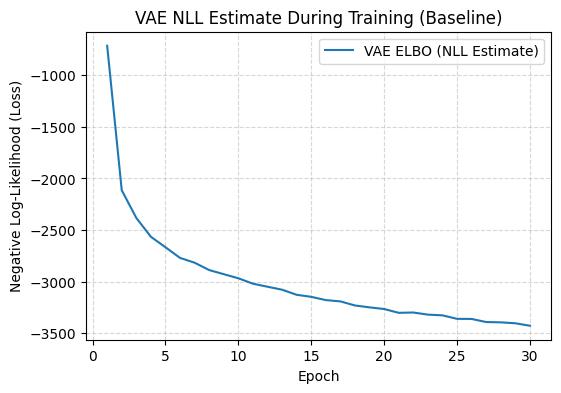

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(vae_history["epoch_loss"]) + 1), vae_history["epoch_loss"], label="VAE ELBO (NLL Estimate)")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood (Loss)")
plt.title("VAE NLL Estimate During Training (Baseline)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.savefig(ARTIFACT_DIR / "vae_nll_plot.png")
plt.show()

## PixelCNN (autoregressive generation)

Ensure the masking logic and loss in `models/pixelcnn.py` are implemented.


In [28]:
pixelcnn_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["small"]
pixelcnn = PixelCNN(
    image_channels=3,
    hidden_channels=pixelcnn_cfg["hidden_channels"],
    residual_layers=pixelcnn_cfg["residual_layers"],
    bins=256,
)
optim_pixelcnn = torch.optim.Adam(pixelcnn.parameters(), lr=pixelcnn_cfg["lr"])
print(f"Baseline PixelCNN parameters: {count_parameters(pixelcnn):,}")


Baseline PixelCNN parameters: 268,992


In [ ]:
PIXELCNN_EPOCHS = pixelcnn_cfg["epochs"]

pixelcnn_history = train_pixelcnn(pixelcnn, train_loader, optimizer=optim_pixelcnn, epochs=PIXELCNN_EPOCHS)
pixelcnn_epoch_times = pixelcnn_history["epoch_time"]  # populate this inside implementation
pixelcnn_train_time = sum(pixelcnn_epoch_times)
print(f"Finished PixelCNN training: {len(pixelcnn_history['loss'])} steps")
print(f"PixelCNN training time per epoch (s): {[round(t, 2) for t in pixelcnn_epoch_times]}")


Finished PixelCNN training: 11730 steps
PixelCNN training time per epoch (s): [19.72, 19.63, 19.46, 19.49, 19.52, 19.66, 19.98, 20.24, 19.7, 19.62, 19.86, 19.72, 19.7, 19.73, 19.68, 19.72, 19.77, 19.7, 19.8, 19.88, 19.58, 19.75, 19.64, 19.54, 19.89, 20.25, 19.85, 19.7, 19.75, 19.68]


In [ ]:
def evaluate_pixelcnn_nll(model: PixelCNN, loader: DataLoader, device=DEVICE):
    model.eval()
    total_loss = 0.0
    total_examples = 0
    with torch.no_grad():
        for batch in loader:
            images = batch["images"].to(device)
            out = model({"images": images})
            loss = out["loss"]
            batch_size = images.size(0)
            total_examples += batch_size
            total_loss += loss.item() * batch_size
    return total_loss / total_examples


# TODO: run once `sample_pixelcnn` is ready.
pixelcnn_nll = evaluate_pixelcnn_nll(pixelcnn, val_loader)
pixelcnn_samples = sample_pixelcnn(pixelcnn, num_samples=16, device=DEVICE)
save_image_grid(pixelcnn_samples, ARTIFACT_DIR / "pixelcnn_samples_baseline.png", nrow=4)

sample_budget = THROUGHPUT_SAMPLES["pixelcnn"]
pixelcnn_samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: sample_pixelcnn(pixelcnn, num_samples=num_images, device=device),
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:pixelcnn_samples_large.size(0)].cpu(), pixelcnn_samples_large.cpu())
record_metrics(
    "PixelCNN",
    "baseline",
    {
        "epochs": PIXELCNN_EPOCHS,
        "params": count_parameters(pixelcnn),
        "kid": kid,
        "nll": pixelcnn_nll,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": pixelcnn_train_time,
        "train_time_per_epoch_s": pixelcnn_train_time / PIXELCNN_EPOCHS,
    },
)

print(f"Validation NLL: {pixelcnn_nll:.4f}")
print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {pixelcnn_samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


#OUTPUT FOR THIS IMPLEMENTATION (complete output contains private filepaths)

# Validation NLL: 3.7810
# KID (x10^3): 0.149
# Sampling time for 1024 images: 62.14 s (throughput 16.48 img/s)

```
Validation NLL: 3.7810
KID (x10^3): 0.149
Sampling time for 1024 images: 62.14 s (throughput 16.48 img/s)
```

> **Scaling experiment:** > **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("PixelCNN", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:


#NOTE redudce batch for debugging

pixel_med_cfg = EXPERIMENT_CONFIGS["pixelcnn"]["medium"]

pixelcnn_med = PixelCNN(
    image_channels=3,
    hidden_channels=pixel_med_cfg["hidden_channels"],
    residual_layers=pixel_med_cfg["residual_layers"],
    bins=256,
)
optim_pixel_med = torch.optim.Adam(pixelcnn_med.parameters(), lr=pixel_med_cfg["lr"])

print(f"Medium PixelCNN parameters: {count_parameters(pixelcnn_med):,}")

print("Training PixelCNN Medium (0-30 epochs)...")
hist_med_30 = train_pixelcnn(pixelcnn_med, train_loader, optim_pixel_med, epochs=30, device=DEVICE)
train_time_30 = sum(hist_med_30["epoch_time"])

nll_30 = evaluate_pixelcnn_nll(pixelcnn_med, val_loader, device=DEVICE)
samples_30 = sample_pixelcnn(pixelcnn_med, num_samples=THROUGHPUT_SAMPLES["pixelcnn"], device=DEVICE)
kid_30 = compute_kid_score(real_subset_device[:samples_30.size(0)].cpu(), samples_30.cpu())

record_metrics("PixelCNN", "scaled-30ep", {
    "epochs": 30,
    "params": count_parameters(pixelcnn_med),
    "kid": kid_30,
    "nll": nll_30,
    "train_time_total_s": train_time_30,
    "train_time_per_epoch_s": train_time_30 / 30,
})
print(f"PixelCNN Medium 30ep KID: {kid_30:.4f}, NLL: {nll_30:.4f}")

print("Training PixelCNN Medium (30-40 epochs)...")
hist_med_10 = train_pixelcnn(pixelcnn_med, train_loader, optim_pixel_med, epochs=10, device=DEVICE)
train_time_total = train_time_30 + sum(hist_med_10["epoch_time"])

nll_40 = evaluate_pixelcnn_nll(pixelcnn_med, val_loader, device=DEVICE)
samples_40 = sample_pixelcnn(pixelcnn_med, num_samples=THROUGHPUT_SAMPLES["pixelcnn"], device=DEVICE)
kid_40 = compute_kid_score(real_subset_device[:samples_40.size(0)].cpu(), samples_40.cpu())

record_metrics("PixelCNN", "scaled-40ep", {
    "epochs": 40,
    "params": count_parameters(pixelcnn_med),
    "kid": kid_40,
    "nll": nll_40,
    "train_time_total_s": train_time_total,
    "train_time_per_epoch_s": train_time_total / 40,
})
print(f"PixelCNN Medium 40ep KID: {kid_40:.4f}, NLL: {nll_40:.4f}")

Medium PixelCNN parameters: 744,480
Training PixelCNN Medium (0-30 epochs)...


PixelCNN Medium 30ep KID: 0.2293, NLL: 3.6014
Training PixelCNN Medium (30-40 epochs)...


PixelCNN Medium 40ep KID: 0.2638, NLL: 3.5563


In [ ]:
steps_per_epoch = len(train_loader)

if "epoch_loss" not in pixelcnn_history or not pixelcnn_history["epoch_loss"]:
    raw_losses = pixelcnn_history["loss"]
    # Determine how many full epochs
    num_epochs_trained = len(raw_losses) // steps_per_epoch
    
    avg_epoch_losses = []
    for i in range(num_epochs_trained):
        # Slice the raw losses for epoch
        epoch_slice = raw_losses[i*steps_per_epoch : (i+1)*steps_per_epoch]
        # Calculate mean
        avg_epoch_losses.append(sum(epoch_slice) / len(epoch_slice))
    
    pixelcnn_history["epoch_loss"] = avg_epoch_losses
    print(f"Recovered {len(avg_epoch_losses)} epochs of loss data for PixelCNN.")

Recovered 30 epochs of loss data for PixelCNN.


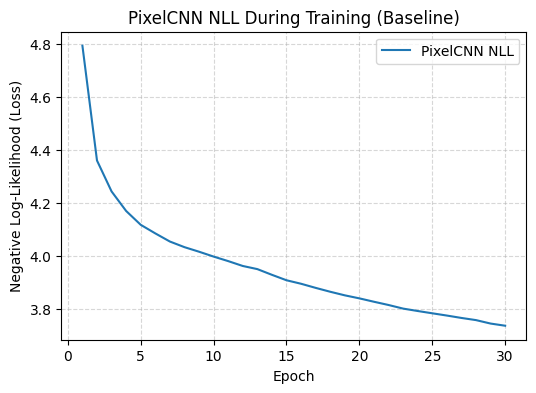

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pixelcnn_history["epoch_loss"]) + 1), pixelcnn_history["epoch_loss"], label="PixelCNN NLL")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood (Loss)")
plt.title("PixelCNN NLL During Training (Baseline)")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.savefig(ARTIFACT_DIR / "pixelcnn_nll_plot.png")
plt.show()

## DDPM (diffusion model)

Verify the diffusion loss path in `models/ddpm.py` before running.

In [38]:
ddpm_cfg = EXPERIMENT_CONFIGS["ddpm"]["small"]
ddpm = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_cfg["base_channels"],
    time_channels=ddpm_cfg["time_channels"],
    timesteps=ddpm_cfg["timesteps"],
)
optim_ddpm = torch.optim.Adam(ddpm.parameters(), lr=ddpm_cfg["lr"])
print(f"Baseline DDPM parameters: {count_parameters(ddpm):,}")


Baseline DDPM parameters: 6,993,987


In [ ]:
DDPM_EPOCHS = ddpm_cfg["epochs"]

ddpm_history = train_ddpm(ddpm, train_loader, optimizer=optim_ddpm, epochs=DDPM_EPOCHS)
ddpm_epoch_times = ddpm_history["epoch_time"] 
ddpm_train_time = sum(ddpm_epoch_times)
print(f"Finished DDPM training: {len(ddpm_history['loss'])} steps")
print(f"DDPM training time per epoch (s): {[round(t, 2) for t in ddpm_epoch_times]}")


Finished DDPM training: 11730 steps
DDPM training time per epoch (s): [35.47, 35.13, 35.21, 35.19, 35.23, 35.05, 35.24, 35.21, 35.26, 35.22, 35.12, 35.1, 35.15, 35.32, 35.31, 35.31, 35.38, 35.39, 35.04, 35.19, 35.33, 35.07, 35.1, 35.35, 35.18, 35.19, 35.19, 35.28, 35.05, 35.1]


In [ ]:
ddpm_samples = sample_ddpm(ddpm, num_samples=64, device=DEVICE)
ddpm_samples_vis = (ddpm_samples + 1.0) / 2.0
save_image_grid(ddpm_samples_vis, ARTIFACT_DIR / "ddpm_samples_baseline.png", nrow=8)

sample_budget = THROUGHPUT_SAMPLES["ddpm"]
samples_large, elapsed, throughput = measure_sampling_throughput(
    lambda num_images, device: (sample_ddpm(ddpm, num_samples=num_images, device=device) + 1.0) / 2.0,
    num_images=sample_budget,
    device=DEVICE,
)

kid = compute_kid_score(real_subset_device[:samples_large.size(0)].cpu(), samples_large.cpu())
record_metrics(
    "DDPM",
    "baseline",
    {
        "epochs": DDPM_EPOCHS,
        "params": count_parameters(ddpm),
        "kid": kid,
        "sampling_time_s": elapsed,
        "throughput_img_per_s": throughput,
        "train_time_total_s": ddpm_train_time,
        "train_time_per_epoch_s": ddpm_train_time / DDPM_EPOCHS,
    },
)

print(f"KID (x10^3): {kid:.3f}")
print(f"Sampling time for {samples_large.size(0)} images: {elapsed:.2f} s (throughput {throughput:.2f} img/s)")


KID (x10^3): 0.054
Sampling time for 1024 images: 190.28 s (throughput 5.38 img/s)


> **Scaling experiment:** Retrain the medium-scale configuration in below and log metrics after 30 and 40 epochs (e.g. `record_metrics("DDPM", "scaled-30ep", {...})` / `"scaled-40ep"`).


In [ ]:
ddpm_med_cfg = EXPERIMENT_CONFIGS["ddpm"]["medium"]

ddpm_med = DenoiseUNet(
    image_channels=3,
    base_channels=ddpm_med_cfg["base_channels"],
    time_channels=ddpm_med_cfg["time_channels"],
    timesteps=ddpm_med_cfg["timesteps"],
)
optim_ddpm_med = torch.optim.Adam(ddpm_med.parameters(), lr=ddpm_med_cfg["lr"])

print(f"Medium DDPM parameters: {count_parameters(ddpm_med):,}")

print("Training DDPM Medium (0-30 epochs)...")
hist_med_30 = train_ddpm(ddpm_med, train_loader, optim_ddpm_med, epochs=30, device=DEVICE)
train_time_30 = sum(hist_med_30["epoch_time"])

samples_30 = sample_ddpm(ddpm_med, num_samples=THROUGHPUT_SAMPLES["ddpm"], device=DEVICE)
samples_30 = (samples_30 + 1.0) / 2.0
kid_30 = compute_kid_score(real_subset_device[:samples_30.size(0)].cpu(), samples_30.cpu())

record_metrics("DDPM", "scaled-30ep", {
    "epochs": 30,
    "params": count_parameters(ddpm_med),
    "kid": kid_30,
    "train_time_total_s": train_time_30,
    "train_time_per_epoch_s": train_time_30 / 30,
})
print(f"DDPM Medium 30ep KID: {kid_30:.4f}")

#remaining 10 epochs (Total 40)
print("Training DDPM Medium (30-40 epochs)...")
hist_med_10 = train_ddpm(ddpm_med, train_loader, optim_ddpm_med, epochs=10, device=DEVICE)
train_time_total = train_time_30 + sum(hist_med_10["epoch_time"])

#Eval at 40
samples_40 = sample_ddpm(ddpm_med, num_samples=THROUGHPUT_SAMPLES["ddpm"], device=DEVICE)
samples_40 = (samples_40 + 1.0) / 2.0
kid_40 = compute_kid_score(real_subset_device[:samples_40.size(0)].cpu(), samples_40.cpu())

record_metrics("DDPM", "scaled-40ep", {
    "epochs": 40,
    "params": count_parameters(ddpm_med),
    "kid": kid_40,
    "train_time_total_s": train_time_total,
    "train_time_per_epoch_s": train_time_total / 40,
})
print(f"DDPM Medium 40ep KID: {kid_40:.4f}")

Medium DDPM parameters: 14,747,107
Training DDPM Medium (0-30 epochs)...


DDPM Medium 30ep KID: 0.0648
Training DDPM Medium (30-40 epochs)...


DDPM Medium 40ep KID: 0.0348


## Summary & export

After running the experiments above (small and medium variants), use the helper below to view logged metrics and export them to disk.

In [ ]:
import json
import pandas as pd

show_metrics()

rows = []
for model_name, variants in experiment_log.items():
    for variant, metrics in variants.items():
        row = {"model": model_name, "variant": variant}
        row.update(metrics)
        rows.append(row)
if rows:
    df_metrics = pd.DataFrame(rows)
    display(df_metrics.set_index(["model", "variant"]))

summary_path = ARTIFACT_DIR / "metrics_summary.json"
with summary_path.open("w") as fp:
    json.dump(experiment_log, fp, indent=2)
print(f"Saved metrics summary to {summary_path}")


#### cell outputs
(old output contains private filepaths)

```
=== DCGAN ===
  [baseline]
    epochs: 30
    params: 1846980
    kid: 0.05774057149887085
    sampling_time_s: 0.0342826209962368
    throughput_img_per_s: 29869.36150863157
    train_time_total_s: 300.2991125821136
    train_time_per_epoch_s: 10.009970419403787
  [scaled-30ep]
    epochs: 30
    params: 3753508
    kid: 0.049681968688964843
    train_time_total_s: 503.0130531829782
    train_time_per_epoch_s: 16.76710177276594
  [scaled-40ep]
    epochs: 40
    params: 3753508
    kid: 0.09507724046707153
    train_time_total_s: 671.5231026737019
    train_time_per_epoch_s: 16.78807756684255
=== VAE ===
  [baseline]
    epochs: 30
    params: 3518214
    kid: 0.2957185363769531
    nll: -3552.8727375
    sampling_time_s: 0.0336171044036746
    throughput_img_per_s: 30460.684171479952
    train_time_total_s: 210.2675405126065
    train_time_per_epoch_s: 7.0089180170868834
  [scaled-30ep]
    epochs: 30
    params: 7906950
    kid: 0.29742711544036865
    nll: -3759.5405484375
    train_time_total_s: 316.91655918210745
    train_time_per_epoch_s: 10.56388530607025
  [scaled-40ep]
    epochs: 40
    params: 7906950
    kid: 0.29134426832199095
    nll: -4163.463940625
    train_time_total_s: 422.1946524470113
    train_time_per_epoch_s: 10.554866311175283
=== PixelCNN ===
  [baseline]
    epochs: 30
    params: 268992
    kid: 0.14879932403564453
    nll: 3.7809781475067137
    sampling_time_s: 62.13922027871013
    throughput_img_per_s: 16.47912534800245
    train_time_total_s: 592.2268658536486
    train_time_per_epoch_s: 19.740895528454953
  [scaled-30ep]
    epochs: 30
    params: 744480
    kid: 0.2292896604537964
    nll: 3.6014157527923585
    train_time_total_s: 1198.44043779606
    train_time_per_epoch_s: 39.948014593202
  [scaled-40ep]
    epochs: 40
    params: 744480
    kid: 0.26377984285354616
    nll: 3.556274016189575
    train_time_total_s: 1596.3866420122795
    train_time_per_epoch_s: 39.90966605030699
=== DDPM ===
  [baseline]
    epochs: 30
    params: 6993987
    kid: 0.05366844654083252
    sampling_time_s: 190.27588987722993
    throughput_img_per_s: 5.3816592352331485
    train_time_total_s: 1056.3762578773312
    train_time_per_epoch_s: 35.212541929244374
  [scaled-30ep]
    epochs: 30
    params: 14747107
    kid: 0.06477227210998535
    train_time_total_s: 1943.733728933148
    train_time_per_epoch_s: 64.7911242977716
  [scaled-40ep]
    epochs: 40
    params: 14747107
    kid: 0.034769551753997804
    train_time_total_s: 2590.9470455218107
    train_time_per_epoch_s: 64.77367613804526
    ```

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th></th>
      <th>epochs</th>
      <th>params</th>
      <th>kid</th>
      <th>sampling_time_s</th>
      <th>throughput_img_per_s</th>
      <th>train_time_total_s</th>
      <th>train_time_per_epoch_s</th>
      <th>nll</th>
    </tr>
    <tr>
      <th>model</th>
      <th>variant</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="3" valign="top">DCGAN</th>
      <th>baseline</th>
      <td>30</td>
      <td>1846980</td>
      <td>0.057741</td>
      <td>0.034283</td>
      <td>29869.361509</td>
      <td>300.299113</td>
      <td>10.009970</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>scaled-30ep</th>
      <td>30</td>
      <td>3753508</td>
      <td>0.049682</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>503.013053</td>
      <td>16.767102</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>scaled-40ep</th>
      <td>40</td>
      <td>3753508</td>
      <td>0.095077</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>671.523103</td>
      <td>16.788078</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th rowspan="3" valign="top">VAE</th>
      <th>baseline</th>
      <td>30</td>
      <td>3518214</td>
      <td>0.295719</td>
      <td>0.033617</td>
      <td>30460.684171</td>
      <td>210.267541</td>
      <td>7.008918</td>
      <td>-3552.872737</td>
    </tr>
    <tr>
      <th>scaled-30ep</th>
      <td>30</td>
      <td>7906950</td>
      <td>0.297427</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>316.916559</td>
      <td>10.563885</td>
      <td>-3759.540548</td>
    </tr>
    <tr>
      <th>scaled-40ep</th>
      <td>40</td>
      <td>7906950</td>
      <td>0.291344</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>422.194652</td>
      <td>10.554866</td>
      <td>-4163.463941</td>
    </tr>
    <tr>
      <th rowspan="3" valign="top">PixelCNN</th>
      <th>baseline</th>
      <td>30</td>
      <td>268992</td>
      <td>0.148799</td>
      <td>62.139220</td>
      <td>16.479125</td>
      <td>592.226866</td>
      <td>19.740896</td>
      <td>3.780978</td>
    </tr>
    <tr>
      <th>scaled-30ep</th>
      <td>30</td>
      <td>744480</td>
      <td>0.229290</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>1198.440438</td>
      <td>39.948015</td>
      <td>3.601416</td>
    </tr>
    <tr>
      <th>scaled-40ep</th>
      <td>40</td>
      <td>744480</td>
      <td>0.263780</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>1596.386642</td>
      <td>39.909666</td>
      <td>3.556274</td>
    </tr>
    <tr>
      <th rowspan="3" valign="top">DDPM</th>
      <th>baseline</th>
      <td>30</td>
      <td>6993987</td>
      <td>0.053668</td>
      <td>190.275890</td>
      <td>5.381659</td>
      <td>1056.376258</td>
      <td>35.212542</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>scaled-30ep</th>
      <td>30</td>
      <td>14747107</td>
      <td>0.064772</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>1943.733729</td>
      <td>64.791124</td>
      <td>NaN</td>
    </tr>
    <tr>
      <th>scaled-40ep</th>
      <td>40</td>
      <td>14747107</td>
      <td>0.034770</td>
      <td>NaN</td>
      <td>NaN</td>
      <td>2590.947046</td>
      <td>64.773676</td>
      <td>NaN</td>
    </tr>
  </tbody>
</table>
</div>

## Aggregate plots

Use this section to generate the plots and figures requested.


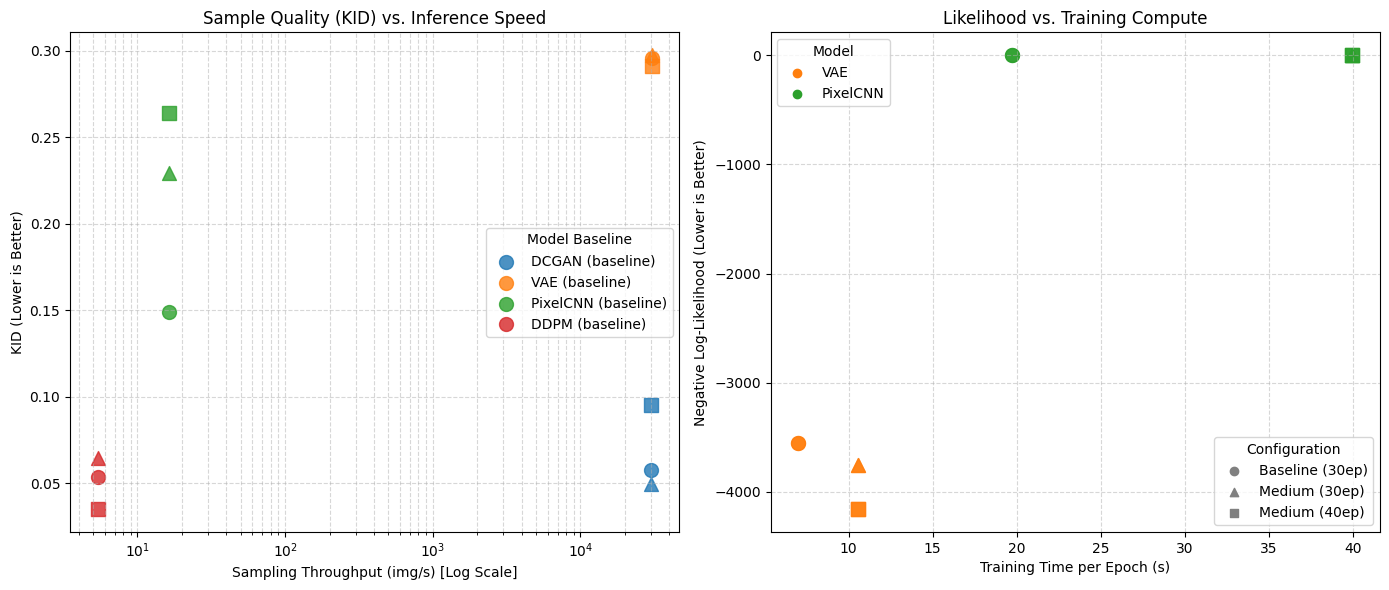

In [ ]:
import matplotlib.pyplot as plt

models = ["DCGAN", "VAE", "PixelCNN", "DDPM"]
markers = {"baseline": "o", "scaled-30ep": "^", "scaled-40ep": "s"}
colors = {"DCGAN": "tab:blue", "VAE": "tab:orange", "PixelCNN": "tab:green", "DDPM": "tab:red"}

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for model in models:
    if model not in experiment_log: continue
    
    for variant, metrics in experiment_log[model].items():
        kid = metrics.get("kid")
        throughput = metrics.get("throughput_img_per_s") or experiment_log[model].get("baseline", {}).get("throughput_img_per_s", 0)
        
        if kid is None or throughput == 0: continue
        
        plt.scatter(throughput, kid, 
                    c=colors[model], 
                    marker=markers.get(variant, "x"), 
                    label=f"{model} ({variant})" if variant == "baseline" else None,
                    s=100, alpha=0.8)

plt.xscale("log")
plt.xlabel("Sampling Throughput (img/s) [Log Scale]")
plt.ylabel("KID (Lower is Better)")
plt.title("Sample Quality (KID) vs. Inference Speed")
plt.grid(True, which="both", ls="--", alpha=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title="Model Baseline")


plt.subplot(1, 2, 2)
likelihood_models = ["VAE", "PixelCNN"]

variant_labels = {"baseline": "Baseline (30ep)", "scaled-30ep": "Medium (30ep)", "scaled-40ep": "Medium (40ep)"}
custom_handles = {}

for model in likelihood_models:
    if model not in experiment_log: continue
    
    for variant, metrics in experiment_log[model].items():
        nll = metrics.get("nll")
        train_time_epoch = metrics.get("train_time_per_epoch_s")
        
        if nll is None or train_time_epoch is None: continue
        
        handle = plt.scatter(train_time_epoch, nll,
                    c=colors[model],
                    marker=markers.get(variant, "x"),
                    label=model, 
                    s=100, alpha=0.8)
        
        if variant not in custom_handles:
            custom_handles[variant] = plt.scatter([], [], c='gray', marker=markers[variant], label=variant_labels[variant])

model_handles, model_labels = [], []
model_labels_set = set()
for model in likelihood_models:
    handle = plt.scatter([], [], c=colors[model], marker='o', label=model)
    model_handles.append(handle)
    model_labels.append(model)
    
variant_handles = list(custom_handles.values())
variant_labels_list = list(custom_handles.keys())

for model in likelihood_models:
    for variant, metrics in experiment_log[model].items():
        nll = metrics.get("nll")
        train_time_epoch = metrics.get("train_time_per_epoch_s")
        if nll is not None and train_time_epoch is not None:
            plt.scatter(train_time_epoch, nll, c=colors[model], marker=markers.get(variant, "x"), s=100, alpha=0.8)


plt.xlabel("Training Time per Epoch (s)")
plt.ylabel("Negative Log-Likelihood (Lower is Better)")
plt.title("Likelihood vs. Training Compute")
plt.grid(True, ls="--", alpha=0.5)

legend1 = plt.legend(model_handles, model_labels, title="Model", loc='upper left')
legend2 = plt.legend(variant_handles, [h.get_label() for h in variant_handles], title="Configuration", loc='lower right')
plt.gca().add_artist(legend1)
plt.tight_layout()
plt.savefig(ARTIFACT_DIR / "aggregate_plots.png")
plt.show()